# Various robust versions of BIM production problem


In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()
helper.install_ipopt()
helper.install_gurobi()
helper.install_xpress()
helper.install_cplex()

import pyomo.environ as pyo
cbc    = pyo.SolverFactory('cbc')
ipopt  = pyo.SolverFactory('ipopt')
cplex  = pyo.SolverFactory('cplex_direct')
gurobi = pyo.SolverFactory('gurobi_direct')
xpress = pyo.SolverFactory('xpress_direct')

%matplotlib inline

pyomo was previously installed
cbc was previously installed
ipopt was previously installed
gurobi was previously installed
Xpress was previously installed
cplex was previously installed


# Original BIM production planning model

The full description of the BIM production problem, can be found here [here](../02/bim.ipynb). The resulting optimization problem was the following LP:

$$
\begin{array}{rrcrcl}
\max    & 12x_1 & + & 9x_2               \\
s.t.    &   x_1 &   &      & \leq & 1000 \\
        &       &   &  x_2 & \leq & 1500 \\
        &   x_1 & + &  x_2 & \leq & 1750 \\
        &  4x_1 & + & 2x_2 & \leq & 4800 \\
        &   x_1 & , &  x_2 & \geq & 0.
\end{array}
$$

In [2]:
def JustSolution( model ):
    return print('The optimal solution is x=',[pyo.value(model.x[t]) for t in chips],'and yields a profit of',pyo.value(model.profit))

chips = [ 'logic', 'memory' ]
profits  = { 'logic' : 12, 'memory' :  9 }
copper     = { 'logic' :  4, 'memory' :  2 }

m = pyo.ConcreteModel('BIM basic problem')

m.x = pyo.Var(chips,within=pyo.NonNegativeReals)

m.profit    = pyo.Objective(expr = pyo.quicksum([profits[t]*m.x[t] for t in chips]), sense=pyo.maximize)

m.silicon  = pyo.Constraint(expr = m.x['logic']  <= 1000)
m.gemanium = pyo.Constraint(expr = m.x['memory'] <= 1500)
m.plastic  = pyo.Constraint(expr = pyo.quicksum([m.x[t] for t in chips]) <= 1750)
m.copper   = pyo.Constraint(expr = pyo.quicksum(copper[t]*m.x[t] for t in chips) <= 4800 ) 

cbc.solve(m)
JustSolution(m)

The optimal solution is x= [650.0, 1100.0] and yields a profit of 17700.0


In [3]:
def ShowDuals( model ):
    import fractions
    # display all duals
    print ("Dual variables:")
    for c in model.component_objects(pyo.Constraint, active=True):
        print ("Constraint ",c)
        for index in c:
            print ("      ", index, str(fractions.Fraction(model.dual[c[index]])))
            

            
m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

cbc.solve(m)
ShowDuals( m )

Dual variables:
Constraint  silicon
       None 0
Constraint  gemanium
       None 0
Constraint  plastic
       None 6
Constraint  copper
       None 3/2


## Uncertainty in copper usage during production

Suppose now that the company BIM notices that not the amount of copper needed for the two types of microchips is not _exactly_ 4 and 2 gr, but varies due to some external factors affecting the production process. How does this uncertainty affect the optimal production plan?

To get a feeling for what happens, let us first perform some simulations and data analysis on them. We start by simulating a sample of observed copper consumptions pairs for the production of 2000 `f` logic chips and 2000 `g` memory chips. The amounts vary around the original values, 4 gr and 2 gr, respectively.

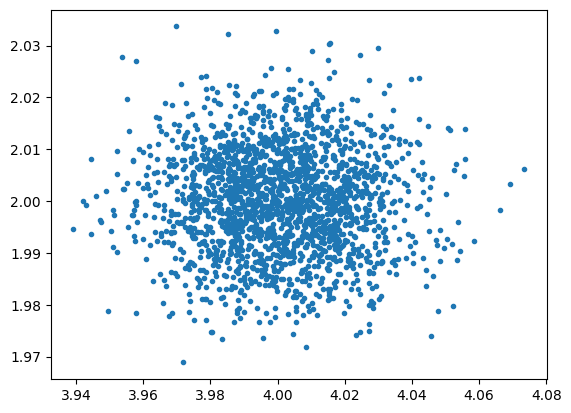

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

n = 2000

f = np.random.lognormal(np.log(4.), .005, n)
g = np.random.lognormal(np.log(2.), .005, n)

plt.figure()
plt.plot( f, g, '.' )
plt.show()

A very simple and somehow naive uncertainty set can be the minimal box that contains all the simulated data.

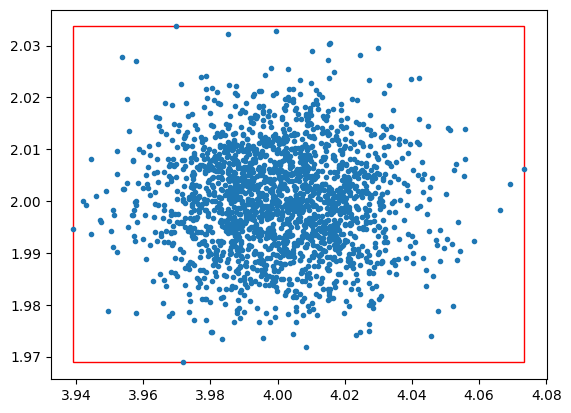

In [5]:
import matplotlib.patches as patches

plt.figure()
plt.plot( f, g, '.' )
currentAxis = plt.gca()
currentAxis.add_patch(patches.Rectangle((min(f), min(g)), max(f)-min(f), max(g)-min(g),fill=False,color='r'))
plt.show()

## A robust model with box uncertainty for copper consumption

BIM wants to be sure that their production does not violate the copper constraint, therefore they consider the following robust variant of their optimization model:

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
s.t.    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & a_1 x_1 & + & a_2 x_2 & \leq & 4800 & \forall \ell \leq a \leq u \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

***

The above model has an infinite number of constraints, one for every realization of the uncertain coefficients $a$. However, using linear duality, we can deal with this and obtain a LP that we can solve. 

The first thing to notice is that the copper consumption is modeled by constraints that are equivalent to bounding the following optimization problem:
    
$$
\begin{array}{rrr}
\max    & x_1 a_1 + x_2 a_2 & \leq 4800 \\
s.t.    & \ell \leq a \leq u 
\end{array}
$$

Or

$$
\begin{array}{rrr}
\max    & x_1 a_1 + x_2 a_2 & \leq 4800 \\
s.t.    & a \leq u \\
        & -a \leq -\ell 
\end{array}
$$

Now we use linear duality to realize that the above is equivalent to:
 
$$
\begin{array}{rrr}
\min    & u y  - \ell w & \leq 4800 \\
s.t.    & y - w = x \\
        & y \geq 0, w \geq 0
\end{array}
$$
    
and the constraint imposed by the last problem is equivalent to:

$$
\begin{array}{rrl}
   & u y  - \ell w & \leq 4800 \\
   & y - w & = x \\
   & y \geq 0, w \geq 0
\end{array}
$$

The only thing we need to do is add the new auxiliary variables and constraints to the original model and implement them in Pyomo.

In [6]:
def BIMWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeReals ):

    m = pyo.ConcreteModel('BIM with Box Uncertainty')

    m.x = pyo.Var(chips,within=domain)

    m.profit    = pyo.Objective(expr = sum([profits[t]*m.x[t] for t in chips]), sense=pyo.maximize)

    m.silicon = pyo.Constraint(expr = m.x['logic']  <= 1000)
    m.germanium = pyo.Constraint(expr = m.x['memory']      <= 1500)
    m.plastic   = pyo.Constraint(expr = sum([m.x[t] for t in chips]) <= 1750)

    m.y = pyo.Var(chips,domain=pyo.NonNegativeReals)
    m.w = pyo.Var(chips,domain=pyo.NonNegativeReals)

    m.robustcopper = pyo.Constraint(expr = sum([upper[t]*m.y[t] - lower[t]*m.w[t] for t in chips]) <= 4800)

    def PerVariable( model, t ):
        return model.x[t] == model.y[t] - model.w[t] 
    
    m.perVariable = pyo.Constraint(chips,rule=PerVariable)

    return m

In [7]:
lower = upper = {}
lower['logic'] = min(f)
upper['logic'] = max(f)
lower['memory'] = min(g)
upper['memory'] = max(g)

m = BIMWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeIntegers )
cbc.solve(m)
JustSolution( m )

The optimal solution is x= [608.0, 1142.0] and yields a profit of 17574.0


We may want to impose the box uncertainty set to be symmetric with respect to the nominal values and just choose its width $\delta$. This leads to a different optimal robust solution.

In [8]:
# you can play with the amount of uncertainty. 
# In particular, if below you make delta equal to 0 you obtain the same result as the nominal model.
delta = 0.05

def BIMWithSymmetricalBoxUncertainty( delta, domain=pyo.NonNegativeIntegers ):
    lower = { chip : copper[chip] - delta for chip in chips }
    upper = { chip : copper[chip] + delta for chip in chips }
    return BIMWithBoxUncertainty( lower, upper, domain=domain )

m = BIMWithSymmetricalBoxUncertainty( delta )
cbc.solve(m)
JustSolution( m )

The optimal solution is x= [606.0, 1144.0] and yields a profit of 17568.0


# Integer optimization

The original BIM model gave integer solutions, but not the robust version. If we need integer solutions then we should impose that to the nature of the variables, which in this case of _box uncertainty_ is easy to do since the model remains linear, although it will be mixed integer. 

In [9]:
m = BIMWithBoxUncertainty( lower, upper, domain=pyo.NonNegativeIntegers )
cbc.solve(m)
JustSolution( m )

The optimal solution is x= [608.0, 1142.0] and yields a profit of 17574.0


Let us see how the optimal solution behave as we vary the width of the box uncertainty set $\delta$ from 0 to 0.5. 

In [15]:
import pandas as pd

df = pd.DataFrame()
for delta in np.linspace(0,.5,21):
    m = BIMWithSymmetricalBoxUncertainty( delta, domain=pyo.NonNegativeIntegers )
    cbc.solve(m)
    results = [ pyo.value(m.profit) ] + [ pyo.value(m.x[i]) for i in chips ]
    df.at[delta,'profit']     = results[0]
    df.at[delta,chips[0]] = results[1]
    df.at[delta,chips[1]] = results[2]
df

,profit,logic,memory
0.000,17700.0,650.0,1100.0
0.025,17634.0,628.0,1122.0
0.050,17568.0,606.0,1144.0
0.075,17502.0,584.0,1166.0
0.100,17436.0,562.0,1188.0
0.125,17370.0,540.0,1210.0
0.150,17304.0,518.0,1232.0
0.175,17238.0,496.0,1254.0
0.200,17175.0,475.0,1275.0
0.225,17109.0,453.0,1297.0


We can visualize how these quantities change as a function of $\delta$:

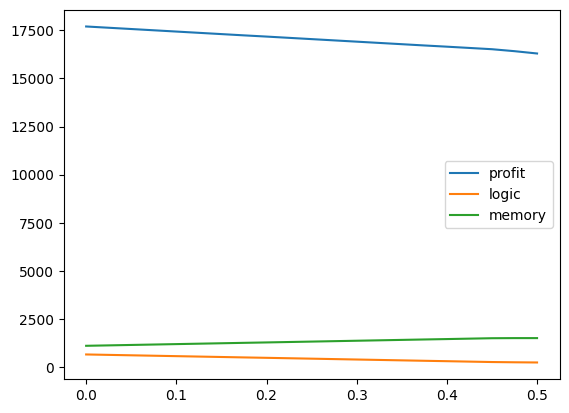

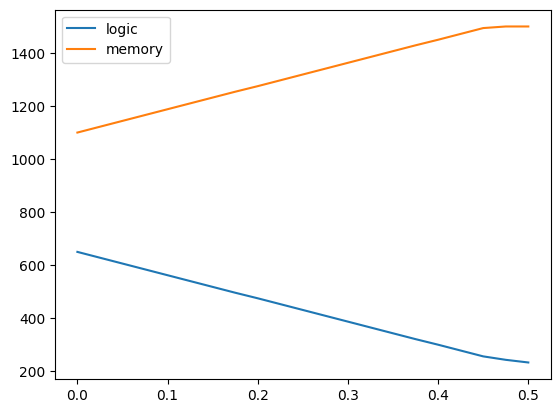

In [19]:
df.plot()
plt.show()

df[['logic','memory']].plot()
plt.show()

# Cardinality constrained uncertainty

Let us now make different assumptions regarding the uncertainty related to the copper consumption.

More specifically, we now assume that each uncertain coefficient $a_j$ may deviate by at most $\pm \delta_j$ from the nominal value $\bar{a}_j$ bun no more than $\Gamma$ will actually deviate.

$$
\begin{array}{rrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
s.t.    &     x_1 &   &         & \leq & 1000 \\
        &         &   &     x_2 & \leq & 1500 \\
        &     x_1 & + &     x_2 & \leq & 1750 \\
        & a_1 x_1 & + & a_2 x_2 & \leq & 4800 & \forall \, a,y \,:\, a_j=\bar{a}_j+\delta_jy_j, \, \|y\|_\infty \leq 1, \, \|y\|_1\leq \Gamma \\
        &     x_1 & , &     x_2 & \geq & 0    \\
\end{array}
$$

Lagrange duality yields the following modification to the problem as equivalent to the robust model stated above:

$$
\begin{array}{rrcrcrcrcrcrcl}
\max    &  12 x_1 & + &   9 x_2               \\
s.t.    &     x_1 &   &         & & & & & & & \leq & 1000 \\
        &         &   &     x_2 & & & & & & & \leq & 1500 \\
        &     x_1 & + &     x_2 & & & & & & & \leq & 1750 \\
        & a_1 x_1 & + & a_2 x_2 & + & \lambda\Gamma & + & z_1 & + & z_2 & \leq & 4800 \\
        &-d_1 x_1 &   &         & + & \lambda & + & z_1 &   &     & \geq & 0 \\
        &         &   &-d_2 x_2 & + & \lambda &   &     & + & z_2 & \geq & 0 \\
        &     x_1 & , &     x_2 & , & \lambda & , & z_1 & , & z_2 & \geq & 0    \\
\end{array}
$$

In [20]:
def BIMWithGammaUncertainty( delta, gamma, domain=pyo.NonNegativeReals ):
    
    m = pyo.ConcreteModel('BIM with Cardinality Constrained Uncertainty')

    m.x = pyo.Var(chips,within=domain)

    m.profit    = pyo.Objective(expr = sum([profits[t]*m.x[t] for t in chips]), sense=pyo.maximize)

    m.silicon = pyo.Constraint(expr = m.x['logic']  <= 1000)
    m.germanium = pyo.Constraint(expr = m.x['memory']      <= 1500)
    m.plastic   = pyo.Constraint(expr = sum([m.x[t] for t in chips]) <= 1750)

    m.z   = pyo.Var(chips,domain=pyo.NonNegativeReals)
    m.lam = pyo.Var(domain=pyo.NonNegativeReals)

    m.robustcopper = pyo.Constraint( \
     expr = sum([copper[t]*m.x[t] for t in chips]) \
          + gamma * m.lam \
          + sum(m.z[t] for t in chips) <= 4800)

    def up_rule( model, t ):
        return model.z[t] >=  delta * model.x[t] - model.lam
    def down_rule( model, t ):
        return model.z[t] >= -delta * model.x[t] - model.lam
    
    m.up   = pyo.Constraint(chips,rule=up_rule)
    m.down = pyo.Constraint(chips,rule=down_rule)

    return m

In [22]:
m = BIMWithGammaUncertainty( 0.01, 2, domain=pyo.NonNegativeIntegers )
cbc.solve(m)
JustSolution(m)

The optimal solution is x= [641.0, 1109.0] and yields a profit of 17673.0


# Ball uncertainty set

Let us now make yet another different assumptions regarding the uncertainty related to the copper consumption.

More specifically, we assume that the two uncertain coefficients $a_1$ and $a_2$ can vary in a 2-dimensional ball centered around the point $(4,2)$ and with radius 1.

A straightforward reformulation leads to that:

$$ 
  a_1x_1+a_2x_2 + \Omega \|x\| \leq 4800
$$

$$
  \Omega \|x\| \leq 4800 - a_1x_1 - a_2x_2
$$
$$
  \|\Omega x\| \leq 4800 - a_1x_1 - a_2x_2
$$

By defining $y = 4800 - a_1x_1 - a_2x_2$ we may write:
$$
  \Omega^2 \|x\|^2 \leq y^2
$$

$$
  (\Omega x_1)^2 + (\Omega x_2)^2 \leq y^2
$$

$$
  \|w\|^2 \leq y^2
$$

with $w = \Omega x$.

We now need to add this newly obtained conic constraint to the original BIM model. The [Pyomo documentation](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/conic.html) says a conic constraint is expressed in 'pyomo' in simple variables and this [table](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/syntax_comparison.html) reports the syntax.

In [23]:
import pyomo.kernel as pyk

def BIMWithBallUncertainty( omega, domain_type=pyk.RealSet ):
    
    idxTrophies = range( len(chips) )
    
    m = pyk.block()

    m.x = pyk.variable_list()
    for i in idxTrophies:
        m.x.append( pyk.variable(lb=0,domain_type=domain_type) )
    
    m.profit    = pyk.objective(expr = sum(profits[chips[i]]*m.x[i] for i in idxTrophies), sense=pyk.maximize)

    m.silicon = pyk.constraint(expr = m.x[0]  <= 1000)
    m.germanium = pyk.constraint(expr = m.x[1]  <= 1500)
    m.plastic   = pyk.constraint(expr = sum([m.x[i] for i in idxTrophies]) <= 1750)

    m.y = pyk.variable(lb=0)
    m.w = pyk.variable_list()
    for i in idxTrophies:
        m.w.append( pyk.variable(lb=0) )

    m.copper = pyk.constraint( expr = m.y == 4800 - sum(copper[chips[i]]*m.x[i] for i in idxTrophies) ) 

    m.xtow = pyk.constraint_list()
    for i in idxTrophies:
        m.xtow.append( pyk.constraint( expr = m.w[i] == omega * m.x[i] ) )

    from pyomo.core.kernel.conic import quadratic
    m.robust = quadratic(m.y,m.w)

    return m

Now the optimization problem is nonlinear, but dedicated solver can levarage the fact that is conic and solve it efficiently. Specifically, `cplex`, `gurobi` and `xpress` support second order cones. On the other hand, `ipotp` is a generic solver for nonlinear optimization problem.

In [53]:
m = BIMWithBallUncertainty( 0.1 )

results = gurobi.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
print('The optimal solution is x=',[round(pyk.value(m.x[i]),3) for i in range(len(m.x))],'and yields a profit of',round(pyk.value(m.profit),3))
print()

results = cplex.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
print('The optimal solution is x=',[round(pyk.value(m.x[i]),3) for i in range(len(m.x))],'and yields a profit of',round(pyk.value(m.profit),3))
print()

results = xpress.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
print('The optimal solution is x=',[round(pyk.value(m.x[i]),3) for i in range(len(m.x))],'and yields a profit of',round(pyk.value(m.profit),3))
print()

results = ipopt.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
print('The optimal solution is x=',[round(pyk.value(m.x[i]),3) for i in range(len(m.x))],'and yields a profit of',round(pyk.value(m.profit),3))
print()

Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.814, 1165.186] and yields a profit of 17504.443

Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.814, 1165.186] and yields a profit of 17504.443


Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.814, 1165.185] and yields a profit of 17504.441

Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.814, 1165.186] and yields a profit of 17504.443



The solvers `cplex`, `gurobi` and `xpress` are capable of solving the mixed integer version of the same model: 

In [52]:
m = BIMWithBallUncertainty( 0.1, domain_type=pyk.IntegerSet )

results = gurobi.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
print('The optimal solution is x=',[round(pyk.value(m.x[i]),3) for i in range(len(m.x))],'and yields a profit of',round(pyk.value(m.profit),3))
print()

results = cplex.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
print('The optimal solution is x=',[round(pyk.value(m.x[i]),3) for i in range(len(m.x))],'and yields a profit of',round(pyk.value(m.profit),3))
print()

results = xpress.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
print('The optimal solution is x=',[round(pyk.value(m.x[i]),3) for i in range(len(m.x))],'and yields a profit of',round(pyk.value(m.profit),3))
print()

Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.0, 1166.0] and yields a profit of 17502.0

Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.0, 1166.0] and yields a profit of 17502.0


Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.0, 1166.0] and yields a profit of 17502.0



# How to implement second order cones using `pyomo.environ`

Noting that $\| x \| \leq t$ is for $t \geq 0$ equivalent to $\| x \|^2 \leq t^2$ and knowing that the commercial solvers (`gurobi`, `cplex` and `express`) support convex quadratic inequalities, we can model this variant in `pyomo.environ` as follows. Note that the essential part to make the model convex is having the right hand side nonnegative.

In [51]:
def BIMWithBallUncertaintyAsSquaredSecondOrderCone(omega, domain=pyo.NonNegativeReals):
    
    m = pyo.ConcreteModel('BIM with Ball Uncertainty as SOC')

    m.x = pyo.Var(chips,within=domain)

    # the nonegativity of this variable is essential!
    m.y = pyo.Var(within=pyo.NonNegativeReals)

    m.profit    = pyo.Objective(expr = sum([profits[t]*m.x[t] for t in chips]), sense=pyo.maximize)

    m.silicon = pyo.Constraint(expr = m.x['logic']  <= 1000)
    m.germanium = pyo.Constraint(expr = m.x['memory']      <= 1500)
    m.plastic   = pyo.Constraint(expr = sum([m.x[t] for t in chips]) <= 1750)
    m.copper      = pyo.Constraint(expr = m.y == 4800 - sum(copper[t]*m.x[t] for t in chips) ) 
    m.robust    = pyo.Constraint(expr = sum((omega*m.x[t])**2 for t in chips) <= m.y**2)
    
    return m

In [54]:
m = BIMWithBallUncertaintyAsSquaredSecondOrderCone( 0.1, domain=pyo.NonNegativeIntegers )

results = cplex.solve(m)
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
JustSolution(m)

Solver status= ok and solver terminal condition= optimal
The optimal solution is x= [584.0, 1166.0] and yields a profit of 17502.0


Note how the verbose `xpress` solver confirms that the convex quadratic constraint is recognized as conic.

In [56]:
m = BIMWithBallUncertaintyAsSquaredSecondOrderCone( 0.1, domain=pyo.NonNegativeIntegers )

results = xpress.solve(m,tee=True)
print()
print('Solver status=',results.solver.status, 'and solver terminal condition=',results.solver.termination_condition )
JustSolution(m)


FICO Xpress v8.14.2, Community, solve started 18:55:47, Oct 25, 2022
Heap usage: 382KB (peak 382KB, 318KB system)
Maximizing MIQCQP BIM with Ball Uncertainty as SOC using up to 12 threads and up to 32GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
         5 rows            3 cols            7 elements         2 globals
         1 qrows           3 qrowelem
Converted 1 second order cones to standard form
Presolved problem has:
         7 rows            7 cols           12 elements         2 globals
         2 cones           4 celems
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 415KB (peak 417KB, 318KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  4.00e+00] / [ 1.00e-01,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+03,  4.80e+03] / [ 1.00e+02,  4.80e+03]
  Objective      [min,max] : [ 9.00e+00,  1.20e+01] / [ 9.00e+00,  1.20e+01]
  Quadratic      [min